In [1]:
library(tidyverse) |> suppressMessages()
library(repr) |> suppressMessages()
library(tidymodels) |> suppressMessages()
library(cowplot) |> suppressMessages()
library(GGally) |> suppressMessages()
options(repr.matrix.max.rows = 6)
#source('tests.R')
#source("cleanup.R")

set.seed(1234)

# Prediction to the risk of heart attack 

## INTRODUCTION

## METHODS AND RESULTS

#### Reading the data

Firstly, our dataset separator is using comma, so we read the data from our github repository using `read_csv` function. Moreover, our data still does not have any column names, so we set `col_names = FALSE`. Beforehand, we decided to download the original data from UCI machine learning repository and move it into our github repository for the sake of accessibility. For additional information, all of the algorithm below are set to some number of seed so that the result is reproducible.

In [2]:
heart_attack_data_raw = read_csv("https://raw.githubusercontent.com/RichardAdhika22/group115/main/processed.hungarian%20(1).data",
                                col_names = FALSE) |> suppressMessages()

heart_attack_data_raw

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


#### Cleaning and tidying the data

Since the dataframe above does not have any column names, we add the columns' name referring to the information given for each column from the UCI machine learning repository (https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/). In the next step, we change the data type for "num" from double to factor, so that we can do classification on the variable `num` (classification can only be done on a factor type variable). Furthermore, we also change the data type of 5 predictors that we are going to use in the prediction (`age`, `trestbps`, `chol`, `thalach`, `oldpeak`) from character type to double type so that we can calculate the euclidean distance for all of the predictors.

In [3]:
colnames(heart_attack_data_raw) = c('age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num')

heart_attack_data_modified = heart_attack_data_raw |>
    mutate(num = as.factor(num),
           age = as.double(age),
           trestbps = as.double(trestbps),
           chol = as.double(chol),
           thalach = as.double(thalach),
           oldpeak = as.double(oldpeak))

heart_attack_data_modified


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,NA,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


#### Selecting only the variables used in the prediction

Here, we choose 5 variables as our predictors as follow: age, trestbps, chol, thalach, oldpeak, num. The reason is because these 5 variables come in the double type, which will be more accurate to use in our prediction compared to the rest (Based on the table above, other variables also come in double type, but they are actually supposed to be factor type).

In [5]:
heart_attack_data_selected = heart_attack_data_modified |>
    select(age,trestbps,chol,thalach,oldpeak,num)|>
    drop_na()

nrow_heart_attack_tidy = nrow(heart_attack_data_selected)

heart_attack_data_selected
nrow_heart_attack_tidy

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0,0
29,120,243,160,0,0
30,170,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮
56,155,342,150,3,1
58,180,393,110,1,1
65,130,275,115,1,1


[1] 270

#### Splitting the data into training and testing set

As a rule of thumb, we should always split our data into training set and testing set when doing a prediction. All of the exploratory analysis and model below will only be built based on the training data. For the testing data, we will only use it to evaluate the accuracy of our prediction and summarize how well our prediction do. Furthermore, we set `strata = num` so that our target class will be spread evenly between the training data and testing data. Lastly, we use 75 percent of our original dataset as our training data using `prop=0.75`.

In [27]:
heart_attack_split = initial_split(heart_attack_data_selected, prop = 0.75, strata = num)
heart_attack_training = training(heart_attack_split)
heart_attack_testing = testing(heart_attack_split)

heart_attack_training
heart_attack_testing

age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
28,130,132,185,0,0
29,120,243,160,0,0
30,170,237,170,0,0
⋮,⋮,⋮,⋮,⋮,⋮
54,130,294,100,0,1
56,155,342,150,3,1
65,130,275,115,1,1


age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
32,110,225,184,0,0
32,125,254,155,0,0
35,120,160,185,0,0
⋮,⋮,⋮,⋮,⋮,⋮
47,160,291,158,3.0,1
50,140,341,125,2.5,1
58,180,393,110,1.0,1


####  Examining the distribution of the prediction target class

Here, we are going to look at the distibution of the prediction target class by calculating the precentage of each class.  In addition, we are also going to plot in a histogram to visualize the distribution.

In [7]:
total_amount = heart_attack_training |>
    summarize("total"=n())|>
    pull()

table_num_count = heart_attack_training |>
    group_by(num) |>
    summarize("total_number_of_num" = n())|>
    mutate("percentage" = total_number_of_num/total_amount*100)

table_num_count 

num,total_number_of_num,percentage
<fct>,<int>,<dbl>
0,126,62.68657
1,75,37.31343


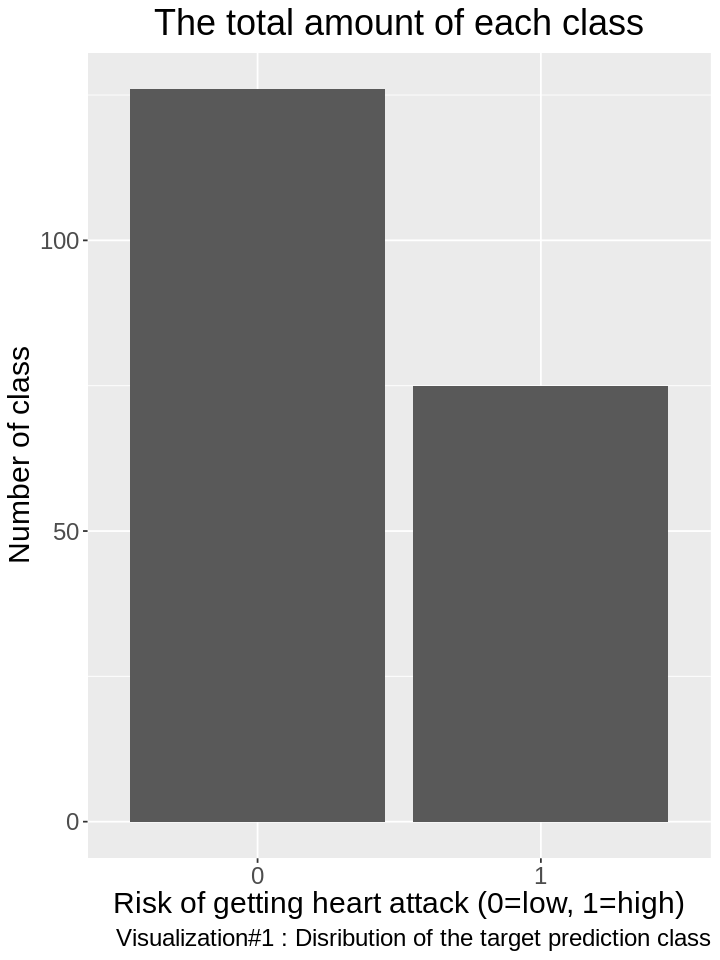

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)

num_count_plot = table_num_count |>
    ggplot(aes(x = num, y = total_number_of_num))+
    geom_bar(stat="identity")+
    labs(x = "Risk of getting heart attack (0=low, 1=high)", y = "Number of class",caption='Visualization#1 : Disribution of the target prediction class')+
    ggtitle("The total amount of each class")+
    theme(text = element_text(size=18), plot.title = element_text(hjust=0.5))

num_count_plot

Looking at the calculation and visualization above, we can conclude that there are more data in the low risk of getting heart attack category (around 63 percent) than the data in the high risk of getting heart attack.

#### The number of omitted observation

We are interested in finding out how many data are missing or incomplete in our original dataset. We decided to remove these data from the dataset because incomplete data (mostly missing one predictor out of 5 predictors) are very difficult to be managed and calculated in building the prediction model.

In [ ]:
missing_data = nrow(heart_attack_data_raw) - nrow_heart_attack_tidy
missing_data

missing_data_percentage = missing_data/nrow(heart_attack_data_raw)
missing_data_percentage

[1] 24

[1] 0.08163265

We obtain that 24 data are incomplete, whcih is roughly 8 percent of the total data. These missing data are usually caused by some technical difficulties, such as incomplete data collecting. This number of percentage is still fine because we still have a lot of data left to work with in building the prediction model. 

#### Data summary of each predictor variable

The next step is to examine the average and standard deviation of each predictor based on their category.
It is important to understand about how the data look like before proceed into building the model.
We do not make a visualization in this case because the scale of every predictor varies, so making a plot will not be useful.

In [31]:
table_means = heart_attack_training |>
    group_by(num) |>
    summarize(across(age:oldpeak,.fns=list('mean'=mean,'sd'=sd)))

age_mean = table_means |>
    select(age_mean)|>
    summarize(age_mean = mean(age_mean))|>
    pull()

trestbps_mean = table_means |>
    select(trestbps_mean)|>
    summarize(trestbps_mean = mean(trestbps_mean))|>
    pull()

chol_mean = table_means |>
    select(chol_mean)|>
    summarize(chol_mean = mean(chol_mean))|>
    pull()

thalach_mean = table_means |>
    select(thalach_mean)|>
    summarize(thalach_mean = mean(thalach_mean))|>
    pull()

oldpeak_mean = table_means |>
    select(oldpeak_mean)|>
    summarize(oldpeak_mean = mean(oldpeak_mean))|>
    pull()

table_means

num,age_mean,age_sd,trestbps_mean,trestbps_sd,chol_mean,chol_sd,thalach_mean,thalach_sd,oldpeak_mean,oldpeak_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,46.65873,8.036081,130.9603,16.69893,241.4444,56.97628,144.0476,21.71888,0.1571429,0.3952576
1,49.92000,7.152320,134.9333,17.92427,275.6400,86.72208,128.4667,21.69278,1.1800000,1.0800400


#### Distribution of each predictor variable

Next, we are going to plot the distribution and spread of all predictors to get a better sense about the predictors that we are using in building the prediction model. We also add a dashed line in each visualization to mark down the average of each predictor.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



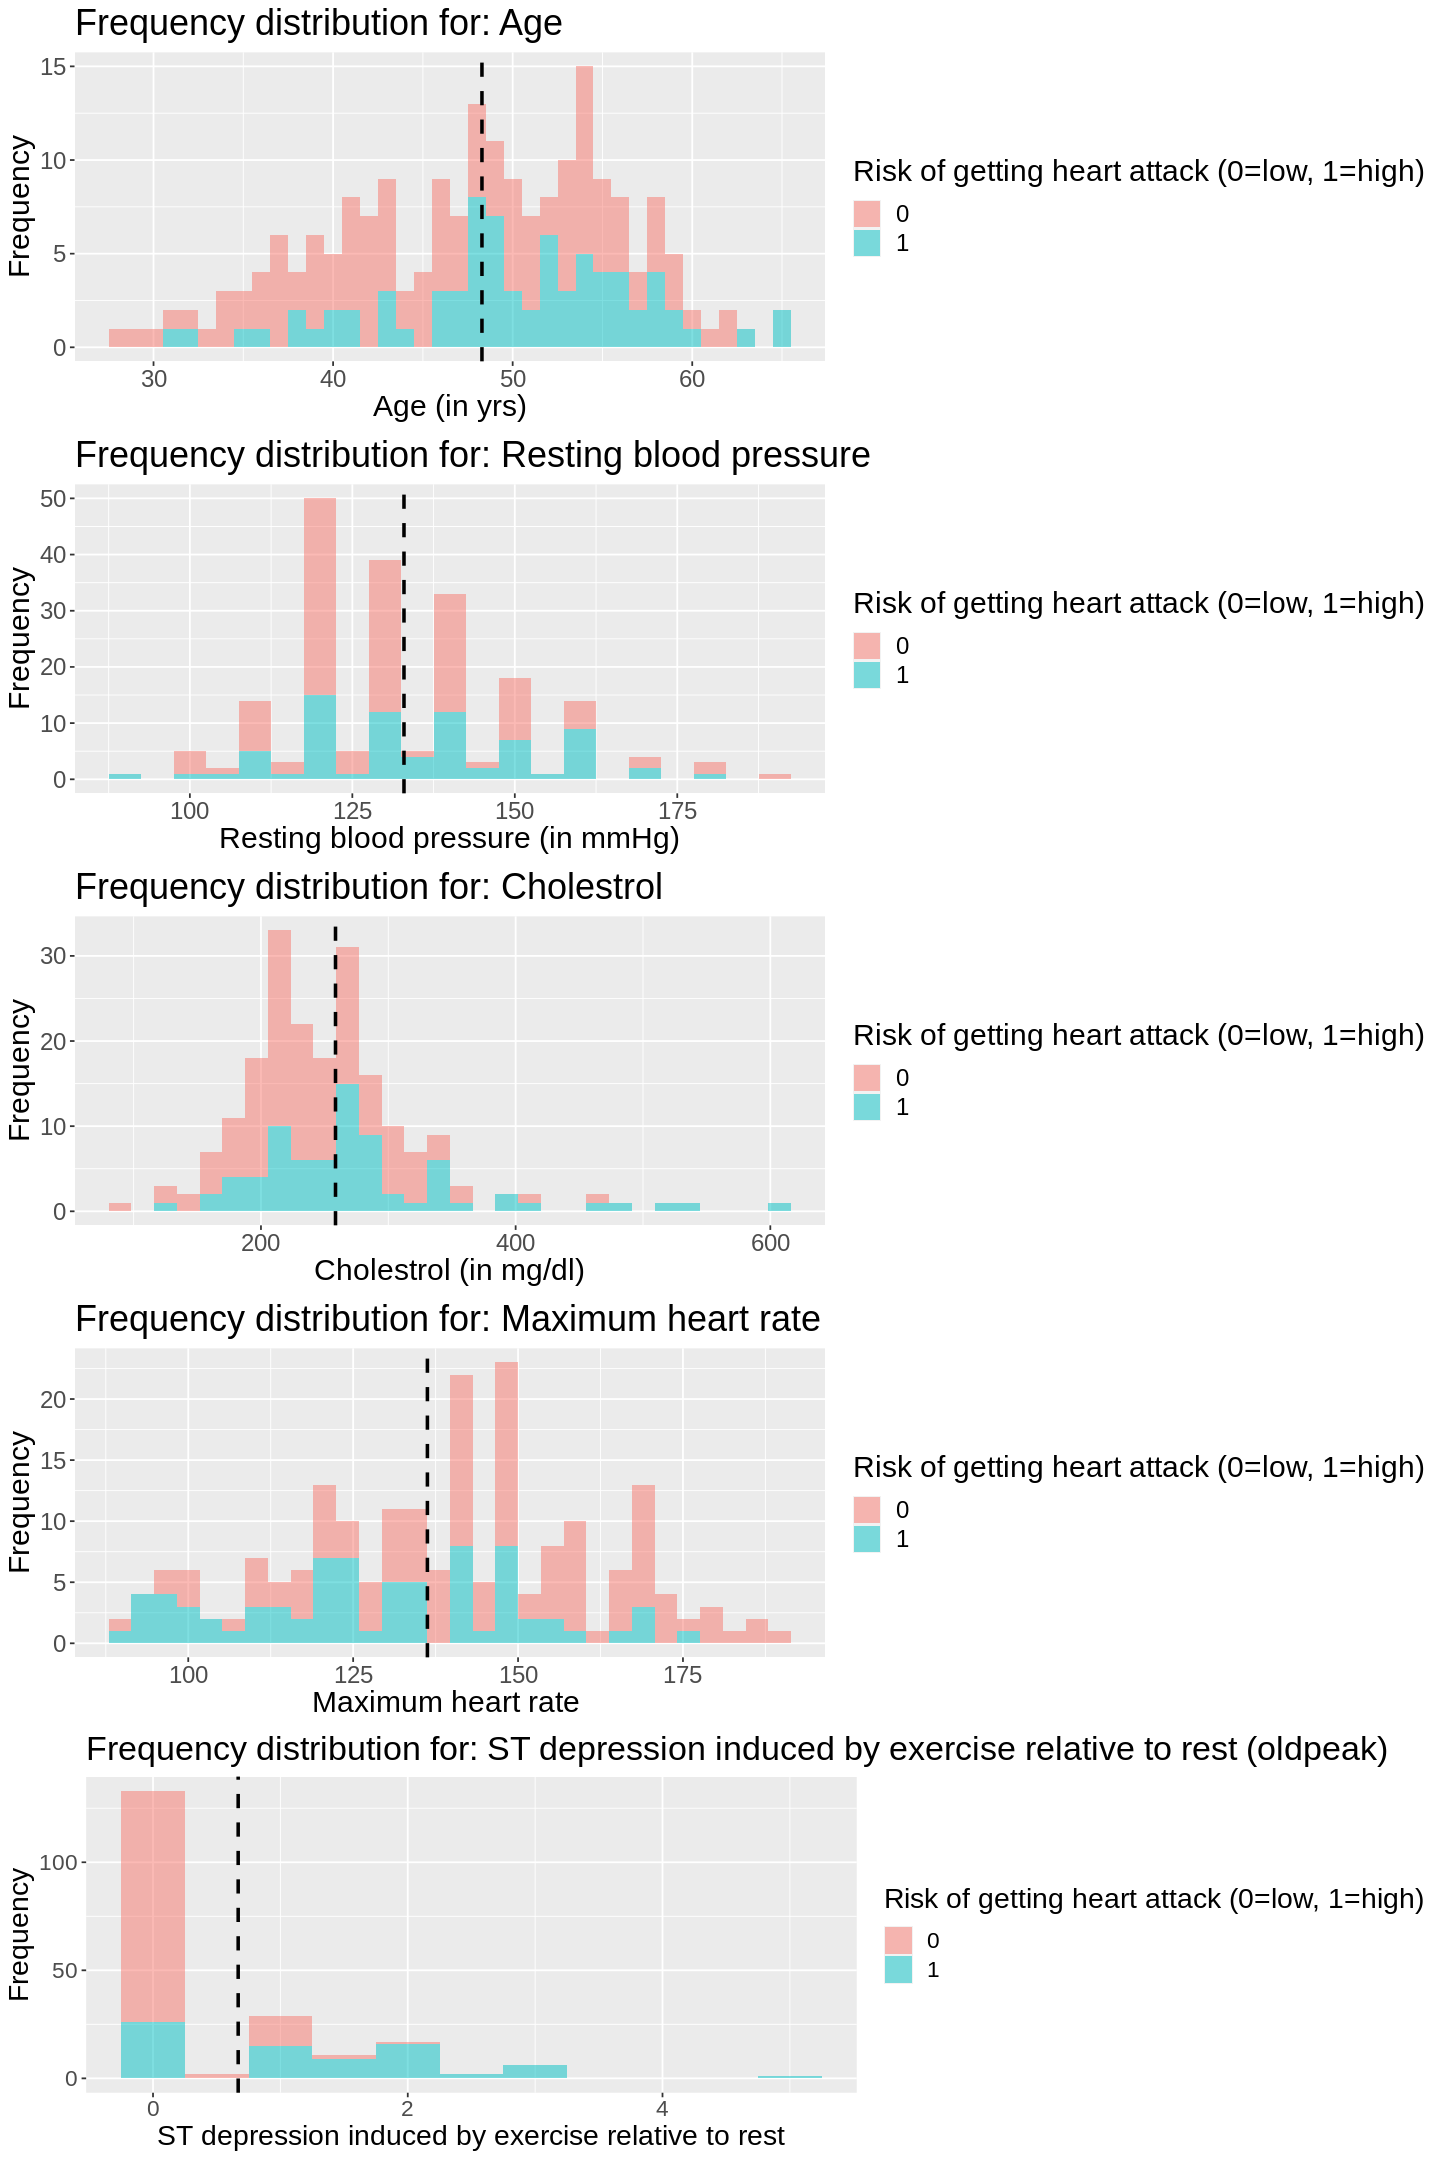

In [71]:
options(repr.plot.width=12, repr.plot.height=18)

age_hist = heart_attack_training |>
    ggplot(aes(x=age, fill=num))+
    geom_histogram(alpha=0.5,binwidth = 1)+
    geom_vline(xintercept = age_mean, linetype = "dashed", size = 1)+
    labs(x = "Age (in yrs)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Age")+
    theme(text = element_text(size=18))

trestbps_hist = heart_attack_training |>
    ggplot(aes(x=trestbps, fill=num))+
    geom_histogram(alpha=0.5, binwidth = 5)+
    geom_vline(xintercept = trestbps_mean, linetype = "dashed", size = 1)+
    labs(x = "Resting blood pressure (in mmHg)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Resting blood pressure")+
    theme(text = element_text(size=18))

chol_hist = heart_attack_training |>
    ggplot(aes(x=chol, fill=num))+
    geom_histogram(alpha=0.5)+
    geom_vline(xintercept = chol_mean, linetype = "dashed", size = 1)+
    labs(x = "Cholestrol (in mg/dl)", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Cholestrol")+
    theme(text = element_text(size=18))

thalach_hist = heart_attack_training |>
    ggplot(aes(x=thalach, fill=num))+
    geom_histogram(alpha=0.5)+
    geom_vline(xintercept = thalach_mean, linetype = "dashed", size = 1)+
    labs(x = "Maximum heart rate ", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: Maximum heart rate")+
    theme(text = element_text(size=18))

oldpeak_hist = heart_attack_training |>
    ggplot(aes(x=oldpeak, fill=num))+
    geom_histogram(alpha=0.5, binwidth = 0.5)+
    geom_vline(xintercept = oldpeak_mean, linetype = "dashed", size = 1)+
    labs(x = "ST depression induced by exercise relative to rest", y = "Frequency", fill = "Risk of getting heart attack (0=low, 1=high)")+
    ggtitle("Frequency distribution for: ST depression induced by exercise relative to rest (oldpeak)")+
    theme(text = element_text(size=17))

plot_grid(age_hist, trestbps_hist, chol_hist, thalach_hist, oldpeak_hist, ncol=1)

Conclusion from the visualization:
- 'age' visualization: spread:25-65, center: roughly 48
- 'trestbps' visualization: spread:90-180, center: roughly 130
- 'chol' visualization: spread:100-600, center: roughly 250
- 'thalach' visualization: spread:80-200, center: roughly 130
- 'oldpeak' visualization: spread:0-5, center: roughly 0.3

#### Relationship between predictors

By using the `ggpairs()` function, we are going to examine the relationshiop between 5 predictors that we are going to use in building the prediction model. 

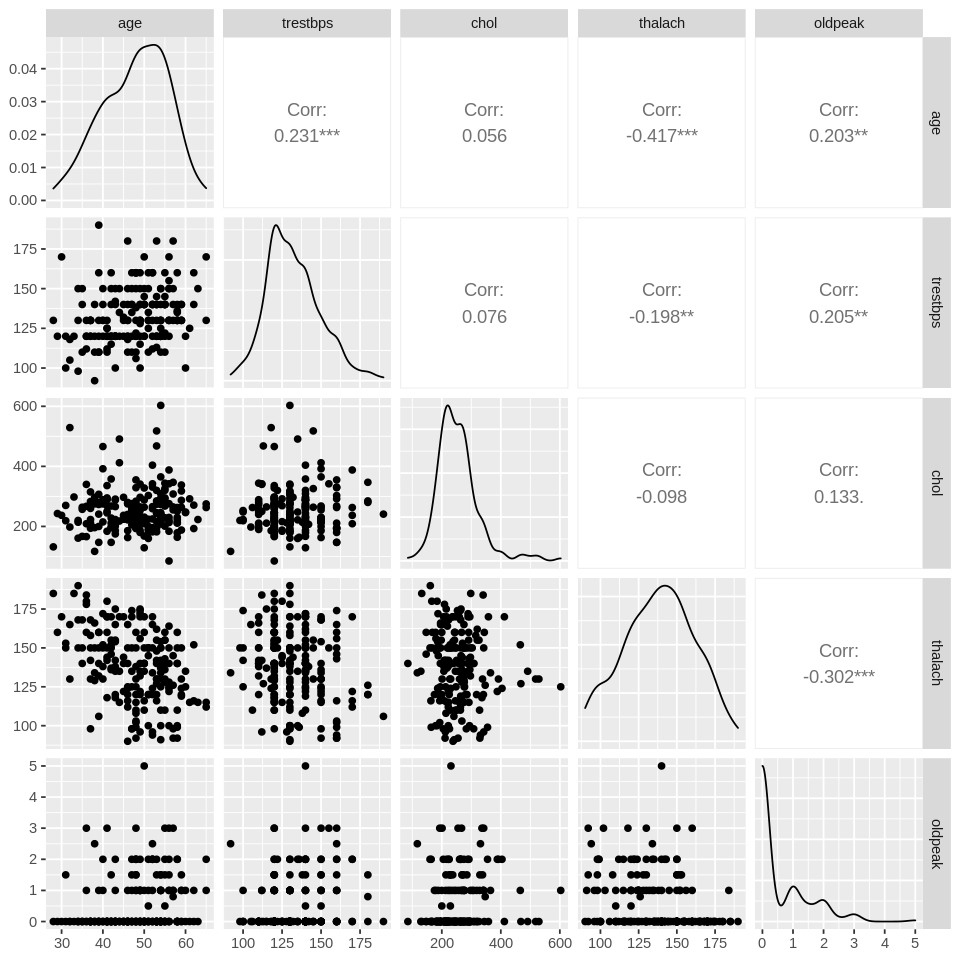

In [72]:
options(repr.plot.width = 8, repr.plot.height = 8)

heart_attack_relationships = heart_attack_training |>
    select(-num)|>
    ggpairs()

heart_attack_relationships

#### Scaling and Centering the variables

In our case, the spread and mean of each variable that we use to predict the target class vary. Therefore, we have to scale and center each value of the predictors so that every predictor will weight the same when calculating the euclidean distance.

In [74]:
heart_attack_recipe = recipe(num ~., data = heart_attack_training)|>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_attack_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### Using cross validation method to choose the best value for k

Below, we are going to use cross-validation method by dividing the training data into 5 parts and again, setting `strata = num`. The sequence of code below is to use the cross validation method across different k values (from 1 to 40) to determine which k value should we pick. We then plot the accuraccy versus the number of k plot.

In [75]:
heart_attack_vfold = vfold_cv(heart_attack_training, v = 5, strata = num)

In [76]:
heart_attack_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")
    
heart_attack_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [78]:
k_values = tibble(neighbors = seq(1,40))

heart_attack_workflow = workflow()|>
    add_recipe(heart_attack_recipe)|>
    add_model(heart_attack_spec)|>
    tune_grid(resamples = heart_attack_vfold, grid = k_values)

In [43]:
heart_attack_accuracies = heart_attack_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy")

heart_attack_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6313415,5,0.02789299,Preprocessor1_Model01
2,accuracy,binary,0.6313415,5,0.02789299,Preprocessor1_Model02
3,accuracy,binary,0.6909756,5,0.04143803,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
38,accuracy,binary,0.7610976,5,0.01311245,Preprocessor1_Model38
39,accuracy,binary,0.7709756,5,0.01510252,Preprocessor1_Model39
40,accuracy,binary,0.7709756,5,0.01510252,Preprocessor1_Model40


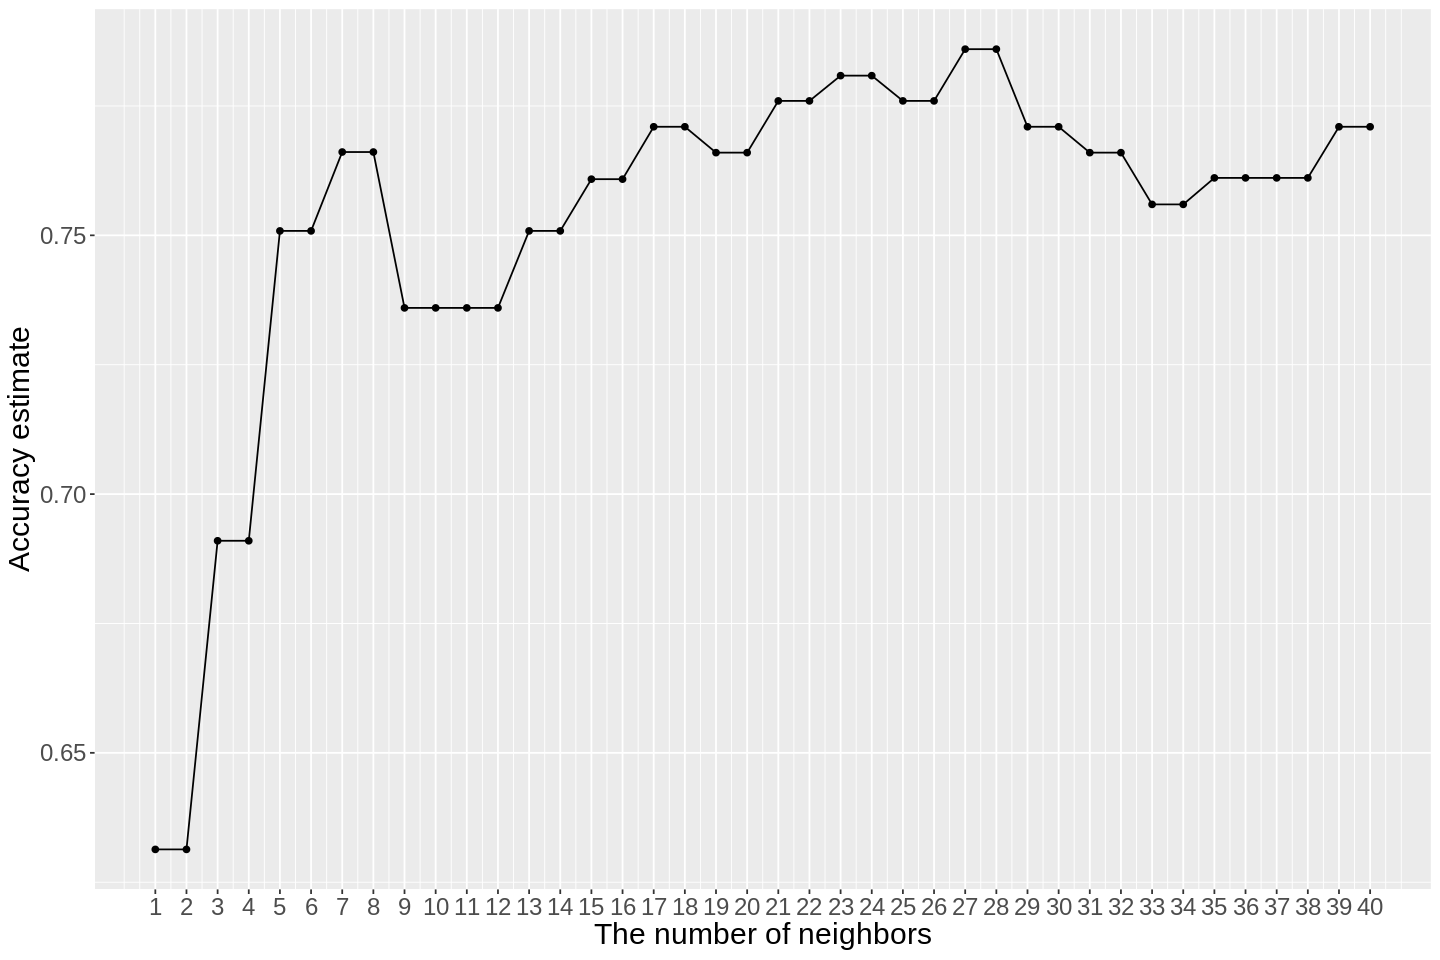

In [54]:
options(repr.plot.width = 12, repr.plot.height = 8)

heart_attack_accuracies_plot = heart_attack_accuracies |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_line()+
    geom_point()+
    labs(x = "The number of neighbors", y = "Accuracy estimate")+
    scale_x_continuous(breaks = seq(1,40, by = 1))+
    theme(text = element_text(size = 18))

heart_attack_accuracies_plot

In [55]:
k_max_value = heart_attack_accuracies |>
    arrange(desc(mean))|>
    slice(1)|>
    select(neighbors)|>
    pull()

k_max_value

[1] 27

From the visualization above, we can see that the highest accuracy is obtained at k = 27. Additionally, this accuracy is quite stable for this value of k, meaning that reducing or adding k by a little does not change the accuracy by a lot.

#### Building the final predicition model using the best value of k

After getting the best value of k = 27, which produce the highest accuracy in the training dataset, we are going to build the final predition model using this value of k. Furthermore, we will calculate the accuracy that we obtain when evaluating our model in the testing data and make a confusion matrix to see how many prediction is wrong for each category.

In [56]:
heart_attack_spec_final = nearest_neighbor(weight_func = "rectangular", neighbors = k_max_value)|>
    set_engine("kknn")|>
    set_mode("classification")

heart_attack_spec_final

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = k_max_value
  weight_func = rectangular

Computational engine: kknn 


In [57]:
heart_attack_result = workflow()|>
    add_recipe(heart_attack_recipe)|>
    add_model(heart_attack_spec_final)|>
    fit(heart_attack_training)

heart_attack_result

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(27L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2288557
Best kernel: rectangular
Best k: 27

In [58]:
heart_attack_prediction = heart_attack_result |>
    predict(heart_attack_testing)|>
    bind_cols(heart_attack_testing)

heart_attack_final_accuracy = heart_attack_prediction |>
    metrics(truth = num, estimate = .pred_class)|>
    filter(.metric == "accuracy")

heart_attack_prediction
heart_attack_final_accuracy

.pred_class,age,trestbps,chol,thalach,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,32,110,225,184,0,0
0,32,125,254,155,0,0
0,35,120,160,185,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,47,160,291,158,3.0,1
1,50,140,341,125,2.5,1
1,58,180,393,110,1.0,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7826087


In [59]:
heart_attack_mnist = heart_attack_prediction |>
    conf_mat(truth = num, estimate = .pred_class)

heart_attack_mnist

          Truth
Prediction  0  1
         0 38 10
         1  5 16